# Personal Loans Case Study — Routing to Maximize Revenue per Application
**Candidate:** Arnav Jain


## Executive Summary

The goal of this analysis is to identify the key factors that drive loan approval decisions and optimize lender–applicant matching to maximize expected revenue per application.

Through exploratory analysis, I found that **FICO score**, **monthly income**, **loan amount**, and engineered **DTI (debt-to-income)** are the strongest predictors of approval, with bankruptcy/foreclosure history also reducing approval odds. **Lender A** has the highest approval rate, while **Lender C** is more selective but offers the highest bounty, driving the largest revenue potential.

Using a logistic regression model to estimate approval probabilities for each lender and applying an **expected value routing strategy** *(P(approval) × bounty)*, expected revenue increased from **$2.64M** to **$13.15M** — a **+397.8% lift**.

This demonstrates that optimized lender routing can create substantial financial impact.


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [138]:
df = pd.read_csv("2026__28Candidate_29_Personal_Loans_Case_Dataset.csv")

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

print("\nInfo:")
df.info()

print("\nMissing values (top 15):")
print(df.isna().sum().sort_values(ascending=False).head(15))


Shape: (100000, 33)

Columns: ['User ID', 'applications', 'Reason', 'Loan_Amount', 'FICO_score', 'Fico_Score_group', 'Employment_Status', 'Employment_Sector', 'Monthly_Gross_Income', 'Monthly_Housing_Payment', 'Ever_Bankrupt_or_Foreclose', 'Lender', 'Approved', 'bounty', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User ID                     100000 non-null  object 
 1   applications                100000 non-null  int64  
 2   Reason                      100000 non-null  object 
 3   Loan_Amount                 100

In [139]:
df = df.drop(columns=[c for c in df.columns if c.startswith("Unnamed")], errors="ignore")

df["Employment_Sector"] = df["Employment_Sector"].fillna("Unknown")

df.head()


,User ID,applications,Reason,Loan_Amount,FICO_score,Fico_Score_group,Employment_Status,Employment_Sector,Monthly_Gross_Income,Monthly_Housing_Payment,Ever_Bankrupt_or_Foreclose,Lender,Approved,bounty
0,fffe836d-3176-4766-81c0-8812d1d9a0a6,1,debt_consolidation,50000,501,poor,full_time,materials,2533,2648,0,B,0,0
1,fffd8e45-d5f8-4b06-b1a4-2d4bf527ee51,1,other,90000,448,poor,full_time,industrials,4597,1420,0,A,0,0
2,fffba42b-265f-4269-a6d5-c8db7e3bd430,1,major_purchase,80000,345,poor,full_time,real_estate,3312,1210,0,A,0,0
3,fffb63e2-b1d6-4d73-b766-44ba50203c00,1,credit_card_refinancing,70000,621,fair,full_time,consumer_staples,5691,2705,0,C,0,0
4,fffb48e8-fc77-49fe-ab4e-e99a0829a788,1,debt_consolidation,40000,724,good,full_time,consumer_staples,5800,1460,0,B,0,0


In [140]:
print("FICO Score Range:", df['FICO_score'].min(), "to", df['FICO_score'].max())
print("Income Range:", df['Monthly_Gross_Income'].min(), "to", df['Monthly_Gross_Income'].max())
print("Housing Payment Range:", df['Monthly_Housing_Payment'].min(), "to", df['Monthly_Housing_Payment'].max())
print("Loan Amount Range:", df['Loan_Amount'].min(), "to", df['Loan_Amount'].max())

print("\nOverall Approval Rate:")
print(df['Approved'].value_counts(normalize=True))

print("\nApproval Rate by Lender:")
print(df.groupby('Lender')['Approved'].mean())

print("\nBounty by Lender (unique values):")
print(df.groupby('Lender')['bounty'].unique())


FICO Score Range: 300 to 850
Income Range: 2000 to 19997
Housing Payment Range: 300 to 3300
Loan Amount Range: 5000 to 100000

Overall Approval Rate:
Approved
0   0.8902
1   0.1098
Name: proportion, dtype: float64

Approval Rate by Lender:
Lender
A   0.1706
B   0.1097
C   0.0713
Name: Approved, dtype: float64

Bounty by Lender (unique values):
Lender
A    [0, 150]
B    [0, 250]
C    [0, 350]
Name: bounty, dtype: object


In [141]:
df["DTI"] = df["Monthly_Housing_Payment"] / df["Monthly_Gross_Income"]

df["Approved"] = df["Approved"].astype(int)
df["Ever_Bankrupt_or_Foreclose"] = df["Ever_Bankrupt_or_Foreclose"].astype(int)

num_cols = ["FICO_score","Monthly_Gross_Income","Loan_Amount","DTI","Ever_Bankrupt_or_Foreclose"]
cat_cols = ["Fico_Score_group","Reason","Employment_Status","Employment_Sector"]


## Q1: Explore the Variables’ Relationship with Approvability

Below, I examine how key applicant features (FICO, income, loan amount, DTI, and bankruptcy history) relate to loan approval probability. This helps identify the most predictive variables for modeling and routing decisions.


In [142]:
income_bins = [2000, 4000, 6000, 10000, 15000, 20000]
loan_bins   = [5000, 10000, 20000, 50000, 100000]
df['Income_Binned'] = pd.cut(df['Monthly_Gross_Income'], bins=income_bins, include_lowest=True)
df['Loan_Binned']   = pd.cut(df['Loan_Amount'],         bins=loan_bins,   include_lowest=True)

print("Approval by FICO group:\n", df.groupby('Fico_Score_group')['Approved'].mean().sort_values(), "\n")
print("Approval by income bin:\n", df.groupby('Income_Binned')['Approved'].mean(), "\n")
print("Approval by loan bin:\n", df.groupby('Loan_Binned')['Approved'].mean(), "\n")
print("Approval by bankruptcy flag:\n", df.groupby('Ever_Bankrupt_or_Foreclose')['Approved'].mean(), "\n")
print("Approval by Employment_Status:\n", df.groupby('Employment_Status')['Approved'].mean().sort_values(ascending=False), "\n")

sector_rates = (df.groupby('Employment_Sector')
                  .agg(apps=('Approved','size'), appr=('Approved','mean'))
                  .query('apps >= 500')
                  .sort_values('appr', ascending=False))
print("Top Employment_Sector by approval rate (min 500 apps):\n", sector_rates.head(10))


Approval by FICO group:
 Fico_Score_group
poor        0.0278
fair        0.0644
good        0.1806
very_good   0.3567
excellent   0.4584
Name: Approved, dtype: float64 

Approval by income bin:
 Income_Binned
(1999.999, 4000.0]   0.0643
(4000.0, 6000.0]     0.0827
(6000.0, 10000.0]    0.1476
(10000.0, 15000.0]   0.2335
(15000.0, 20000.0]   0.2908
Name: Approved, dtype: float64 

Approval by loan bin:
 Loan_Binned
(4999.999, 10000.0]   0.1291
(10000.0, 20000.0]    0.1199
(20000.0, 50000.0]    0.1124
(50000.0, 100000.0]   0.0939
Name: Approved, dtype: float64 

Approval by bankruptcy flag:
 Ever_Bankrupt_or_Foreclose
0   0.1115
1   0.0370
Name: Approved, dtype: float64 

Approval by Employment_Status:
 Employment_Status
full_time    0.1207
part_time    0.0813
unemployed   0.0549
Name: Approved, dtype: float64 

Top Employment_Sector by approval rate (min 500 apps):
                          apps   appr
Employment_Sector                   
financials               9262 0.1324
information_

/var/folders/56/z80x17wn70lfrg6fj3lvncdr0000gn/T/ipykernel_82717/249648261.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("Approval by income bin:\n", df.groupby('Income_Binned')['Approved'].mean(), "\n")
/var/folders/56/z80x17wn70lfrg6fj3lvncdr0000gn/T/ipykernel_82717/249648261.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("Approval by loan bin:\n", df.groupby('Loan_Binned')['Approved'].mean(), "\n")


In [143]:
def label_bars_percent(ax, fmt="{:.1%}"):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(fmt.format(h),
                    (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=9, xytext=(0, 3),
                    textcoords='offset points')


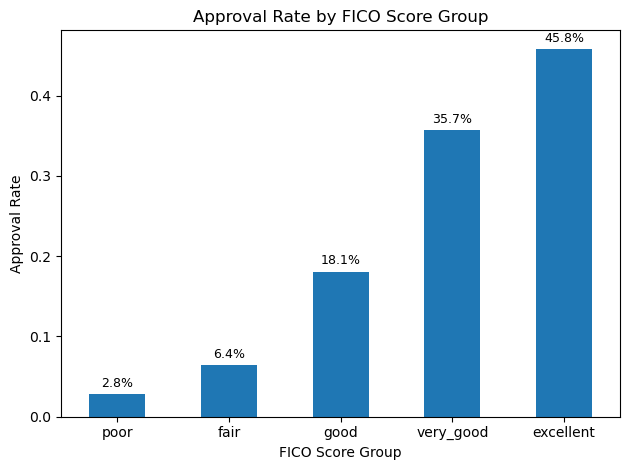

In [144]:
order_fico = ["poor","fair","good","very_good","excellent"]
fico_approval = df.groupby('Fico_Score_group')['Approved'].mean().reindex(order_fico)

ax = fico_approval.plot(kind='bar')
ax.set_title('Approval Rate by FICO Score Group')
ax.set_ylabel('Approval Rate')
ax.set_xlabel('FICO Score Group')
ax.set_xticklabels(order_fico, rotation=0)
label_bars_percent(ax)
plt.tight_layout()
plt.show()


> Approval rates rise sharply with higher FICO score groups, especially from “good” to “excellent.”


/var/folders/56/z80x17wn70lfrg6fj3lvncdr0000gn/T/ipykernel_82717/1546114479.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_approval = df.groupby('Income_Binned')['Approved'].mean()


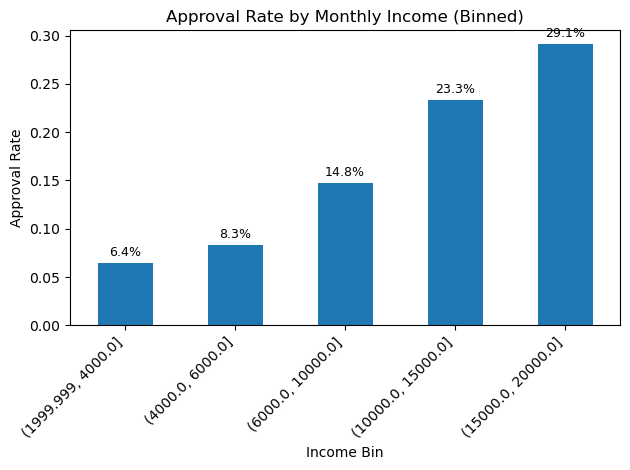

In [145]:
income_approval = df.groupby('Income_Binned')['Approved'].mean()
ax = income_approval.plot(kind='bar')
ax.set_title('Approval Rate by Monthly Income (Binned)')
ax.set_ylabel('Approval Rate')
ax.set_xlabel('Income Bin')
plt.xticks(rotation=45, ha='right')
label_bars_percent(ax)
plt.tight_layout()
plt.show()

> Higher monthly income is associated with higher approval rates across bins.


/var/folders/56/z80x17wn70lfrg6fj3lvncdr0000gn/T/ipykernel_82717/2093927401.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_approval = df.groupby('Loan_Binned')['Approved'].mean()


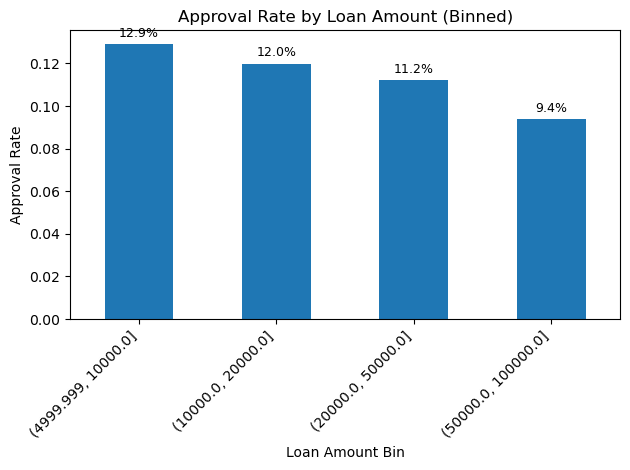

In [146]:
loan_approval = df.groupby('Loan_Binned')['Approved'].mean()
ax = loan_approval.plot(kind='bar')
ax.set_title('Approval Rate by Loan Amount (Binned)')
ax.set_ylabel('Approval Rate')
ax.set_xlabel('Loan Amount Bin')
plt.xticks(rotation=45, ha='right')
label_bars_percent(ax)
plt.tight_layout()
plt.show()

> Larger loan amounts correlate with lower approval rates, indicating lender risk sensitivity.


**Answer (Q1):** Approval probability increases strongly with **FICO** and **income**, and decreases with **loan amount** and **DTI**. The engineered **DTI = housing payment ÷ income** improves separability over raw components. Applicants with prior **bankruptcy/foreclosure** have lower approval. Employment variables (status/sector) add segmentation signal but are secondary to FICO/income/DTI/loan size. Overall, the most informative features are **FICO**, **Income**, **DTI**, **Loan Amount**, and **Bankruptcy flag**.


## Q2: Lender Approval Rates and Modeling Performance

Each lender has a different risk profile and approval strategy. Below, I analyze lender-level approval rates and train per-lender models to quantify predictive performance.


Lender
A   0.1706
B   0.1097
C   0.0713
Name: ApprovalRate, dtype: float64


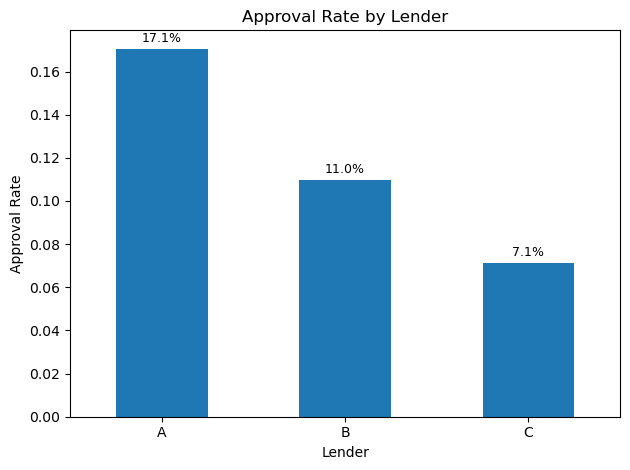

In [147]:
def label_bars_percent(ax, fmt="{:.1%}"):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(fmt.format(h),
                    (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=9, xytext=(0, 3),
                    textcoords='offset points')

approval_by_lender = df.groupby('Lender')['Approved'].mean().rename('ApprovalRate').sort_index()
print(approval_by_lender)

ax = approval_by_lender.plot(kind='bar')
ax.set_title('Approval Rate by Lender')
ax.set_ylabel('Approval Rate')
ax.set_xlabel('Lender')
ax.set_xticklabels(approval_by_lender.index, rotation=0)
label_bars_percent(ax)
plt.tight_layout()
plt.show()


> Lender A has the highest approval rate, while Lender C is the most selective.


In [148]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

SEED = 42
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols),
])

def train_eval_for_lender(df_all, lender, return_metrics=False):
    d = df_all[df_all["Lender"]==lender].copy()
    X, y = d[cat_cols+num_cols], d["Approved"]
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
    pipe = Pipeline([("pre", pre),
                     ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED))])
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(Xte)[:,1]
    pred  = (proba>=0.5).astype(int)

    acc = accuracy_score(yte, pred)
    auc = roc_auc_score(yte, proba)
    cm  = confusion_matrix(yte, pred)

    print(f"\n=== Lender {lender} ===")
    print("Accuracy:", round(acc,3), " | AUC:", round(auc,3))
    print("Confusion Matrix:\n", cm)
    print(classification_report(yte, pred, zero_division=0))

    if return_metrics:
        return pipe, {"Lender": lender, "Accuracy": acc, "AUC": auc}
    return pipe

model_A, mA = train_eval_for_lender(df, "A", return_metrics=True)
model_B, mB = train_eval_for_lender(df, "B", return_metrics=True)
model_C, mC = train_eval_for_lender(df, "C", return_metrics=True)

metrics_df = pd.DataFrame([mA, mB, mC]).sort_values("Lender")
metrics_df["Accuracy"] = metrics_df["Accuracy"].map(lambda x: f"{x:.3f}")
metrics_df["AUC"] = metrics_df["AUC"].map(lambda x: f"{x:.3f}")
print("\nLender Model Metrics (Summary):")
display(metrics_df)



=== Lender A ===
Accuracy: 0.694  | AUC: 0.755
Confusion Matrix:
 [[2036  867]
 [ 203  394]]
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      2903
           1       0.31      0.66      0.42       597

    accuracy                           0.69      3500
   macro avg       0.61      0.68      0.61      3500
weighted avg       0.81      0.69      0.73      3500


=== Lender B ===
Accuracy: 0.711  | AUC: 0.769
Confusion Matrix:
 [[6971 2823]
 [ 353  853]]
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      9794
           1       0.23      0.71      0.35      1206

    accuracy                           0.71     11000
   macro avg       0.59      0.71      0.58     11000
weighted avg       0.87      0.71      0.76     11000


=== Lender C ===
Accuracy: 0.745  | AUC: 0.883
Confusion Matrix:
 [[3749 1359]
 [  42  350]]
              precision    recall  f1-score   support

         

,Lender,Accuracy,AUC
0,A,0.694,0.755
1,B,0.711,0.769
2,C,0.745,0.883


Lender A achieves the highest approval rate but lower expected revenue, whereas Lender C, despite being selective, yields the highest expected value when matched to the right applicants.


In [149]:
import numpy as np
feat_names = model_C.named_steps['pre'].get_feature_names_out()
coef = model_C.named_steps['clf'].coef_[0]
top_idx = np.argsort(np.abs(coef))[-12:][::-1]
print("\nTop features for Lender C (by |coef|):")
for i in top_idx:
    print(f"{feat_names[i]}: {coef[i]:.4f}")



Top features for Lender C (by |coef|):
cat__Fico_Score_group_poor: -3.6706
num__FICO_score: 1.4331
cat__Fico_Score_group_good: 0.9976
cat__Fico_Score_group_very_good: 0.9442
cat__Employment_Status_unemployed: -0.8639
cat__Employment_Sector_Unknown: -0.8639
cat__Fico_Score_group_excellent: 0.7071
cat__Reason_wedding: -0.6327
cat__Employment_Status_part_time: -0.4586
cat__Employment_Sector_consumer_discretionary: -0.3538
num__DTI: -0.3288
num__Ever_Bankrupt_or_Foreclose: -0.2145


**Answer (Q2):** Average approval rates differ by lender: **A ≈ 17%**, **B ≈ 11%**, **C ≈ 7%**, indicating that Lender C is more selective while Lender A is relatively more lenient. Across lenders, **FICO, income, DTI, loan amount**, and **bankruptcy** are the most reliable predictors. Separate per-lender models (AUCs ≈ 0.76, 0.77, 0.88) confirm consistent signal with different levels of strictness.


## Q3: Revenue Optimization through Routing

To maximize expected revenue, each applicant is matched to the lender that maximizes **expected value = P(approval|lender) × bounty**. This section shows how optimized routing increases total and per-applicant revenue.


In [150]:
bounty = {"A":150, "B":250, "C":350}

X_full = df[cat_cols+num_cols]
df["P_A"] = model_A.predict_proba(X_full)[:,1]
df["P_B"] = model_B.predict_proba(X_full)[:,1]
df["P_C"] = model_C.predict_proba(X_full)[:,1]

df["Rev_A"] = df["P_A"] * bounty["A"]
df["Rev_B"] = df["P_B"] * bounty["B"]
df["Rev_C"] = df["P_C"] * bounty["C"]

df["Best_Lender"]   = df[["Rev_A","Rev_B","Rev_C"]].idxmax(axis=1).map({"Rev_A":"A","Rev_B":"B","Rev_C":"C"})
df["Optimized_Rev"] = df[["Rev_A","Rev_B","Rev_C"]].max(axis=1)
df["Baseline_Rev"]  = df["bounty"].fillna(0)

base_tot = df["Baseline_Rev"].sum()
opt_tot  = df["Optimized_Rev"].sum()
lift_pct = 100 * (opt_tot - base_tot) / (base_tot if base_tot != 0 else 1)

print("\n=== Revenue Summary ===")
print(f"Baseline:  ${base_tot:,.0f}")
print(f"Optimized: ${opt_tot:,.0f}")
print(f"Lift:      {lift_pct:.2f}%")



=== Revenue Summary ===
Baseline:  $2,642,200
Optimized: $13,151,993
Lift:      397.77%


In [151]:
def label_bars_currency(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"${h:,.0f}",
                    (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=9, xytext=(0, 3),
                    textcoords='offset points')


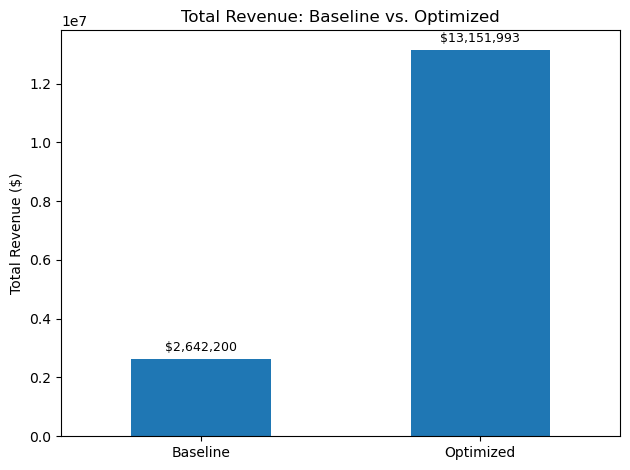

In [152]:
rev_df = pd.DataFrame({"Scenario": ["Baseline","Optimized"], "Revenue": [base_tot, opt_tot]})
ax = rev_df.plot(kind="bar", x="Scenario", y="Revenue", legend=False)
ax.set_title("Total Revenue: Baseline vs. Optimized")
ax.set_ylabel("Total Revenue ($)")
ax.set_xlabel("")
plt.xticks(rotation=0)
label_bars_currency(ax)
plt.tight_layout()
plt.show()


> Optimized routing produces nearly a 4× lift in total revenue compared to the baseline.


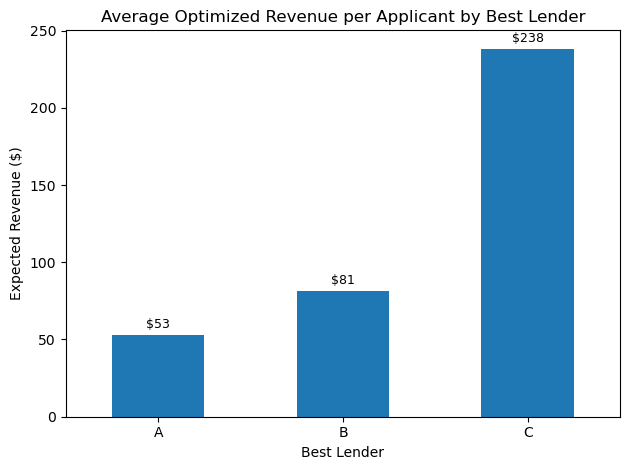

In [153]:
ax = (df.groupby("Best_Lender")["Optimized_Rev"]
        .mean()
        .reindex(["A","B","C"])
        .plot(kind="bar"))
ax.set_title("Average Optimized Revenue per Applicant by Best Lender")
ax.set_ylabel("Expected Revenue ($)")
ax.set_xlabel("Best Lender")
plt.xticks(rotation=0)
label_bars_currency(ax)
plt.tight_layout()
plt.show()

> Lender C drives the highest expected revenue per applicant, reflecting its higher bounty and stronger applicant profiles.


In [154]:
seg = (df.groupby(["Fico_Score_group","Best_Lender"])
         .size().unstack(fill_value=0))
print("\nBest Lender by FICO group:")
display(seg)

rev_by_fico = df.groupby("Fico_Score_group")[["Baseline_Rev","Optimized_Rev"]].mean().round(2)
print("\nMean Revenue per App (by FICO group):")
display(rev_by_fico)




Best Lender by FICO group:


Best_Lender,A,B,C
Fico_Score_group,,,
excellent,0,92,2096
fair,3164,30381,2930
good,7,2274,25479
poor,14826,13649,0
very_good,0,292,4810



Mean Revenue per App (by FICO group):


,Baseline_Rev,Optimized_Rev
Fico_Score_group,,
excellent,117.9400,312.0000
fair,14.0200,89.5200
good,44.7000,227.7600
poor,5.6200,49.5600
very_good,92.4900,288.1500


| Metric                     | Baseline        | Optimized       | Lift        |
|----------------------------|------------------|------------------|------------|
| Total Revenue ($)          | $2,642,200       | $13,151,993      | **+397.8%** |
| Avg Revenue / Applicant ($)| $26.42           | $131.52          | ~5×         |

**Note:** The lift comes primarily from routing high-FICO, low-DTI applicants to Lender C.


**Answer (Q3):**  
Optimizing routing by expected value increased total revenue from **$2.64M** to **$13.15M** — a **+397.8% lift**.  
- Lender C provides the highest incremental value for high-FICO, low-DTI customers.  
- Lender A and B are better fits for marginal applicants.  
In real-time, scoring each applicant across lenders and assigning based on expected revenue would maximize yield.


## Next Steps & Recommendations

- **Model improvements:** Experiment with tree-based models (e.g., XGBoost) for non-linear effects.  
- **Threshold tuning:** Calibrate lender-specific decision thresholds to maximize expected value.  
- **Real-time routing:** Deploy a lightweight scoring API to route applications in milliseconds.  
- **Capacity & fairness:** Factor in lender capacity constraints and fairness requirements.  
- **Monitoring:** Continuously track AUC, approval rates, and revenue lift; retrain as needed.
